传感器间距为 0.6 米  
曲率和波长满足关系式：  
$k = c\frac{\lambda - \lambda _{0} }{\lambda } $,其中c = 4200

In [36]:
import numpy as np
import matplotlib.pyplot as plt
t1_original = np.array([1529 for i in range(6)])
t1 = np.array([0.808,0.807,0.813,0.812,0.814,0.809]) + 1529
t2_original = np.array([1540 for i in range(6)])
t2 = np.array([0.095,0.092,0.09,0.093,0.094,0.091]) + 1540
t1, t1_original, t2, t2_original

(array([1529.808, 1529.807, 1529.813, 1529.812, 1529.814, 1529.809]),
 array([1529, 1529, 1529, 1529, 1529, 1529]),
 array([1540.095, 1540.092, 1540.09 , 1540.093, 1540.094, 1540.091]),
 array([1540, 1540, 1540, 1540, 1540, 1540]))

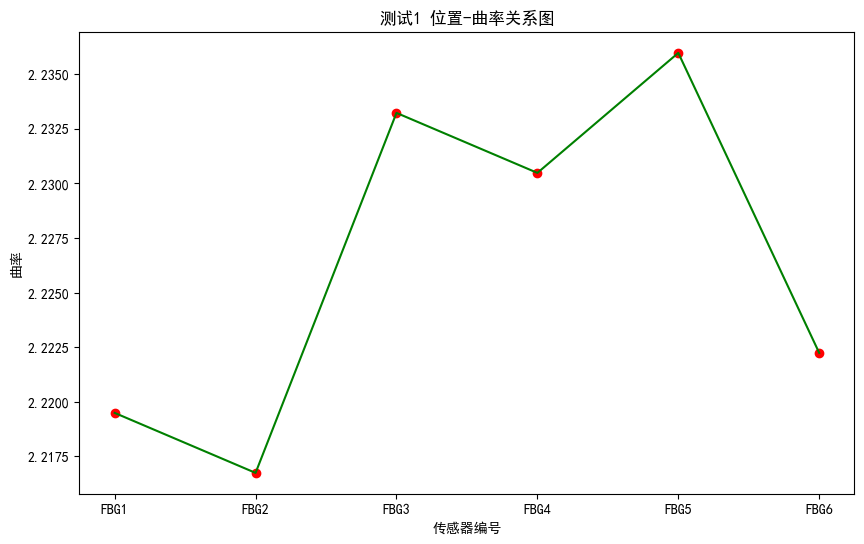

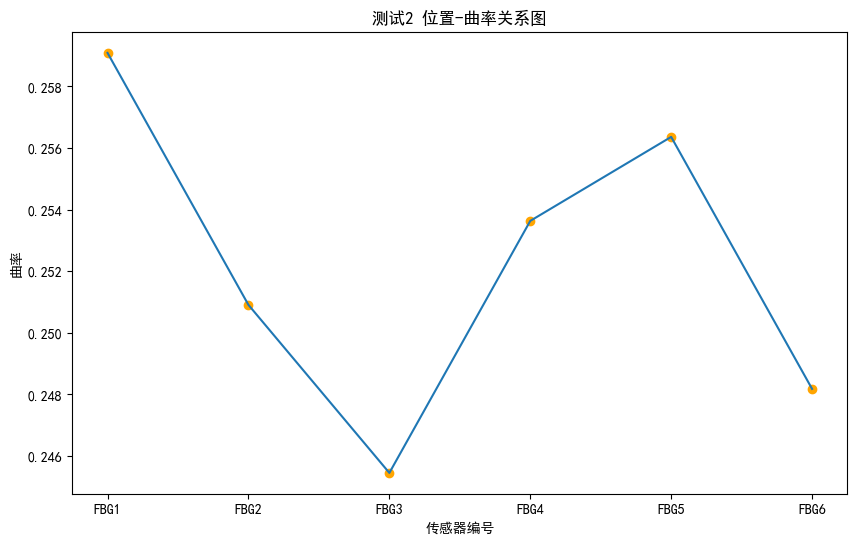

In [37]:
k1s = np.array([4200 * ((i / 1529) - 1) for i in t1])
k2s = np.array([4200 * ((i / 1540) - 1) for i in t2])
# 启用中文图例
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 绘制FBG1至FBG6的位置-曲率关系图
x = ['FBG' + str(i) for i in range(1, 7)]
plt.figure(figsize=(10, 6))
plt.title('测试1 位置-曲率关系图')
plt.xlabel('传感器编号')
plt.ylabel('曲率')
plt.plot(x, k1s, label='曲率',color='green')
plt.scatter(x, k1s,color='red',label='曲率')
plt.figure(figsize=(10, 6))
plt.title('测试2 位置-曲率关系图')
plt.xlabel('传感器编号')
plt.ylabel('曲率')
plt.plot(x, k2s, label='曲率')
plt.scatter(x, k2s,color='orange',label='曲率') 
plt.show()

假设初始点坐标为原点，初始的水平光纤方向为x轴，垂直方向为y轴，光纤在平面内受力后在初始位置的切线与水平方向的夹角为45°，请建立模型估算下列表格中横坐标x轴相应位置处的曲率。

问题三：
根据$y = x^{3} + x$，以适当的额等间距弧长采样，计算这些点的曲率，然后以采样的曲率为基础，构建数学模型，重构平面曲线，并分析重构曲线与原始曲线出现误差的原因。 

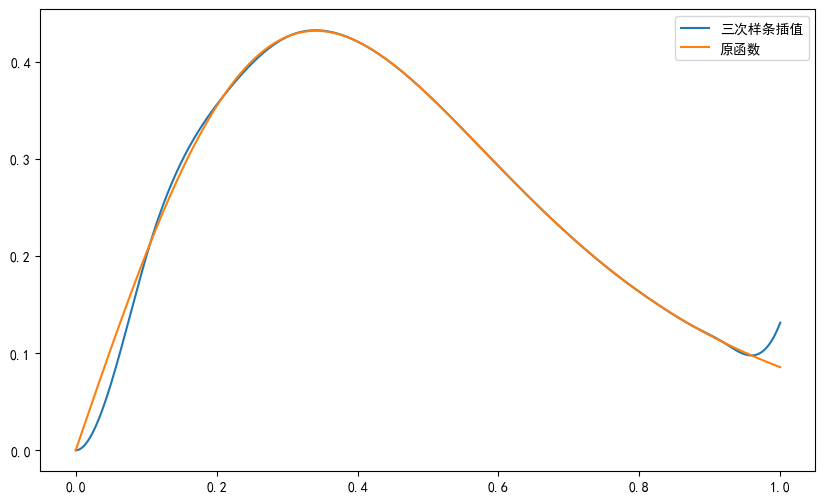

In [51]:
import scipy
def f(x):
    return x**3 + x
def ds(x):
    return np.sqrt(1 + (3*x**2 + 1)**2)
def df(x):
    return 3*x**2 + 1
def d2f(x):
    return 6*x 
s,err = scipy.integrate.quad(ds, 0, 1) # 积分计算弧长
# 等弧长采样
points = 15
# 每段弧的长度
l = s / points
x = [0]
cur_length = 0
x0 = 0
while len(x) < points:
    x0 += 0.0001
    cur_length = scipy.integrate.quad(ds, x[-1], x0)[0] # 计算当前弧长
    if abs(cur_length - l) < 1e-3:
        x.append(x0)
y = [f(i) for i in x]
# 计算各个采样点的曲率
k = []
for i in range(len(x)):
    k.append(abs(d2f(x[i]) / (1 + df(x[i])**2)**1.5))
# 三次样条插值重构每个采样点周围的曲率
cs = scipy.interpolate.CubicSpline(x, k, bc_type='clamped') # 三次样条插值
# 生成更多点用于插值
x_interp = np.linspace(0, 1, 1000)
k_interp = cs(x_interp)
x_interp, k_interp
# 计算原函数中各个点的曲率
k0 = []
for i in x_interp:
    k0.append(abs(d2f(i) / (1 + df(i)**2)**1.5))
# 使用线性插值计算原函数中各个点的曲率

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(x_interp, k_interp, label='三次样条插值')  
plt.plot(x_interp, k0, label='原函数')
plt.legend()
plt.show()

# 斜率递推算法重建曲线  
$k_{n+1} = \tan [\kappa _{n}\Delta s_{n}+\tan^{-1}(k_{n})]$  
$\Delta x = \frac{\Delta s_{n} }{\sqrt {1+k_n ^ {2}}} $  
$\Delta y = \frac{k_{n} \Delta s_{n} }{\sqrt {1+k_n ^ {2}}}$  
根据实际情况，一般会知道要重构曲线的原点，原点斜率，弧长  
设置初始点为原点，初始斜率设定为1，每两个采样点（包含插值点）间的弧长 = 总长度 / 点的总数，已知采样点和插值出的各个点的曲率，以此重构曲线

1000 1000


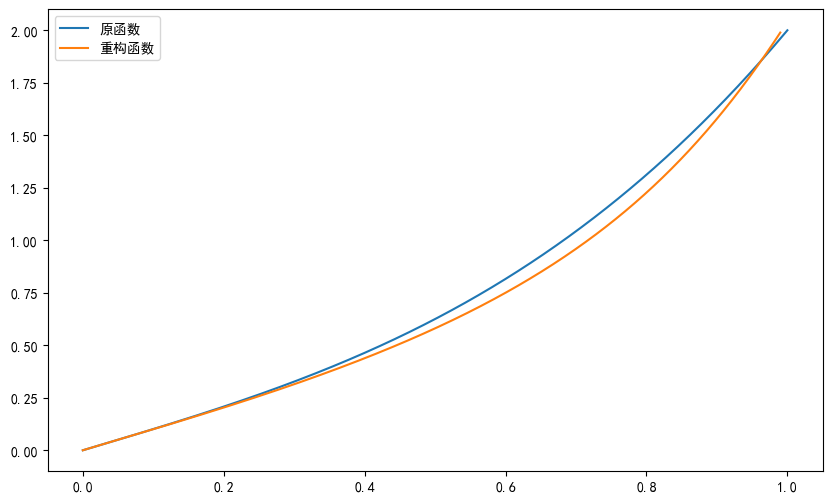

In [74]:
# 依据初始条件和上式计算每个点的斜率
ds = s / 1000 # 每段弧长
tan0 = df(0) # 初始斜率
tans = [tan0]
for i in range(len(x_interp)): # 递推计算每个点的斜率
    next_tan = np.tan(k_interp[i] * ds + np.arctan(tans[-1]))
    tans.append(next_tan)
# 以原点为起点，递推计算每个点的坐标
pts = [(0, 0)]
for i in range(len(x_interp)):
    nx = pts[-1][0] + (ds / np.sqrt(1 + tans[i]**2))
    ny = pts[-1][1] + (ds * tans[i] / np.sqrt(1 + tans[i]**2))
    pts.append((nx, ny))
# 修正最后一个点的坐标
pts = pts[:-1]
print(len(pts),len(x_interp))
# 绘图
plt.figure(figsize=(10, 6))
plt.plot(x_interp,[f(i) for i in x_interp], label='原函数')
plt.plot([i[0] for i in pts], [i[1] for i in pts], label='重构函数')
plt.legend()
plt.show()

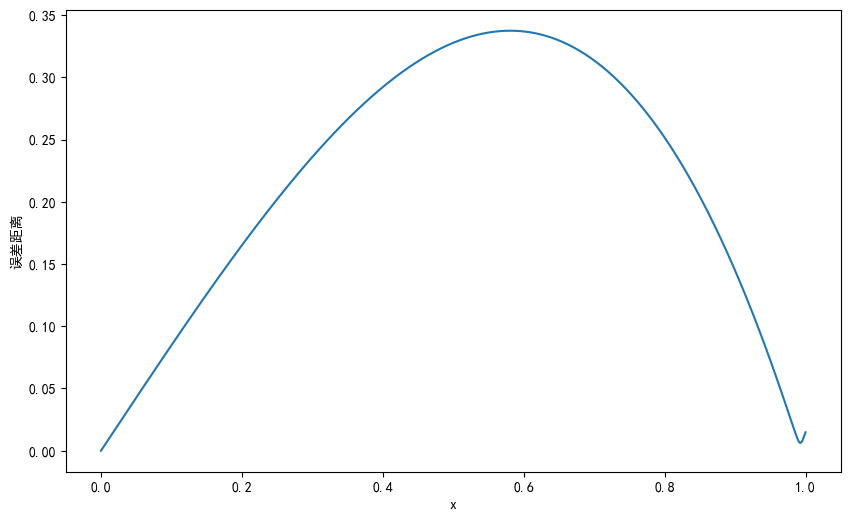

In [75]:
# 计算每个点的误差
err = []
for i in range(len(pts)):
    err.append(np.sqrt((pts[i][0] - x_interp[i])**2 + (pts[i][1] - f(x_interp[i]))**2)) # 计算欧氏距离
# 绘图
plt.figure(figsize=(10, 6))
plt.plot(x_interp, err)
plt.xlabel('x')
plt.ylabel('误差距离')
plt.show()